# Desempenho de algoritmos de classificação na detecção de intrusão em redes de dispositivos IoT

## Importações

In [206]:
import glob
import os
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Variáveis globais

In [207]:
DATASET_DIRECTORY = "./CICIoT2023/"
GENERATE_DATASETS = False
EIGHT_CLASSES = True

## DTOs

In [208]:
@dataclass
class ModelDataset:
    x_train: np.ndarray
    y_train: np.ndarray
    x_test: pl.DataFrame
    y_test: np.ndarray

## Funções auxiliares

In [209]:
def sample_rows(
    group_by: pl.dataframe.group_by.GroupBy, percentage: float
) -> pl.DataFrame:
    dfs = []
    for _, df in group_by:
        if len(df) * percentage <= 1:
            dfs.append(df.sample(n=1))
            continue
        dfs.append(df.sample(fraction=percentage))

    return pl.concat(dfs)


def generate_dataframe(file_list: list, percentage: float) -> pl.DataFrame:
    dfs = []
    for file in file_list:
        df = pl.read_csv(file)
        dfs.append(
            sample_rows(
                group_by=df.group_by(["label"], maintain_order=True),
                percentage=percentage,
            )
        )
    return pl.concat(dfs)

# Criando um dataset menor

In [210]:
file_dir = "./data/"
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

df_sets = sorted(glob.glob(os.path.join(DATASET_DIRECTORY, "*.csv")))

In [211]:
if GENERATE_DATASETS:
    generate_dataframe(file_list=df_sets, percentage=0.001).write_csv(
        file="./data/dataset_dev.csv"
    )

In [212]:
if GENERATE_DATASETS:
    generate_dataframe(file_list=df_sets, percentage=0.01).write_csv(
        file="./data/dataset_one_percent.csv"
    )

# IDS

## Dataset

In [213]:
df = pl.read_csv("./data/dataset_dev.csv")
training_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

### Separando Features e Label

In [214]:
X_columns = df.columns[:-1]
y_column = "label"

In [215]:
del df

### 8 Classes

In [216]:
if EIGHT_CLASSES:
    eight_classes = {}

    eight_classes["BenignTraffic"] = "Benign"

    eight_classes["DDoS-RSTFINFlood"] = "DDoS"
    eight_classes["DDoS-PSHACK_Flood"] = "DDoS"
    eight_classes["DDoS-SYN_Flood"] = "DDoS"
    eight_classes["DDoS-UDP_Flood"] = "DDoS"
    eight_classes["DDoS-TCP_Flood"] = "DDoS"
    eight_classes["DDoS-ICMP_Flood"] = "DDoS"
    eight_classes["DDoS-SynonymousIP_Flood"] = "DDoS"
    eight_classes["DDoS-ACK_Fragmentation"] = "DDoS"
    eight_classes["DDoS-UDP_Fragmentation"] = "DDoS"
    eight_classes["DDoS-ICMP_Fragmentation"] = "DDoS"
    eight_classes["DDoS-SlowLoris"] = "DDoS"
    eight_classes["DDoS-HTTP_Flood"] = "DDoS"

    eight_classes["DoS-UDP_Flood"] = "DoS"
    eight_classes["DoS-SYN_Flood"] = "DoS"
    eight_classes["DoS-TCP_Flood"] = "DoS"
    eight_classes["DoS-HTTP_Flood"] = "DoS"

    eight_classes["Mirai-greeth_flood"] = "Mirai"
    eight_classes["Mirai-greip_flood"] = "Mirai"
    eight_classes["Mirai-udpplain"] = "Mirai"

    eight_classes["Recon-PingSweep"] = "Recon"
    eight_classes["Recon-OSScan"] = "Recon"
    eight_classes["Recon-PortScan"] = "Recon"
    eight_classes["VulnerabilityScan"] = "Recon"
    eight_classes["Recon-HostDiscovery"] = "Recon"

    eight_classes["DNS_Spoofing"] = "Spoofing"
    eight_classes["MITM-ArpSpoofing"] = "Spoofing"

    eight_classes["BrowserHijacking"] = "Web"
    eight_classes["Backdoor_Malware"] = "Web"
    eight_classes["XSS"] = "Web"
    eight_classes["Uploading_Attack"] = "Web"
    eight_classes["SqlInjection"] = "Web"
    eight_classes["CommandInjection"] = "Web"

    eight_classes["DictionaryBruteForce"] = "BruteForce"

    training_data = training_data.with_columns(
        pl.col(y_column).replace(eight_classes, default=-1)
    )
    test_data = test_data.with_columns(
        pl.col(y_column).replace(eight_classes, default=-1)
    )

## Classes

### Separando as colunas

In [217]:
X_train = training_data.select(X_columns)
y_train = training_data.select(y_column)
X_test = test_data.select(X_columns)
y_test = test_data.select(y_column).to_numpy()

### Balanceando o dataset

In [218]:
training_data.group_by("label").len()

label,len
str,u32
"""DoS""",6359
"""Recon""",679
"""Spoofing""",297
"""Benign""",821
"""DDoS""",26723
"""Web""",820
"""BruteForce""",128
"""Mirai""",1914


In [219]:
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)

pd_X_resampled, pd_y_resampled = ros.fit_resample(
    X_train.to_pandas(), y_train.to_pandas()
)
X_resampled, y_resampled = pl.from_pandas(pd_X_resampled), pl.from_pandas(pd_y_resampled)

### Normalizando o dataset

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# a

In [221]:
data = ModelDataset(
    x_train=X_train_scaled,
    y_train=y_resampled.to_numpy(),
    x_test=X_test_scaled,
    y_test=y_test,
)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

      Benign       0.58      0.56      0.57       195
  BruteForce       0.51      0.46      0.49        41
        DDoS       0.97      0.90      0.93      6726
         DoS       0.68      0.89      0.77      1580
       Mirai       1.00      0.99      0.99       457
       Recon       0.55      0.57      0.56       166
    Spoofing       0.60      0.43      0.50        77
         Web       0.56      0.68      0.61       194

    accuracy                           0.88      9436
   macro avg       0.68      0.68      0.68      9436
weighted avg       0.89      0.88      0.88      9436



<Figure size 2000x1000 with 0 Axes>

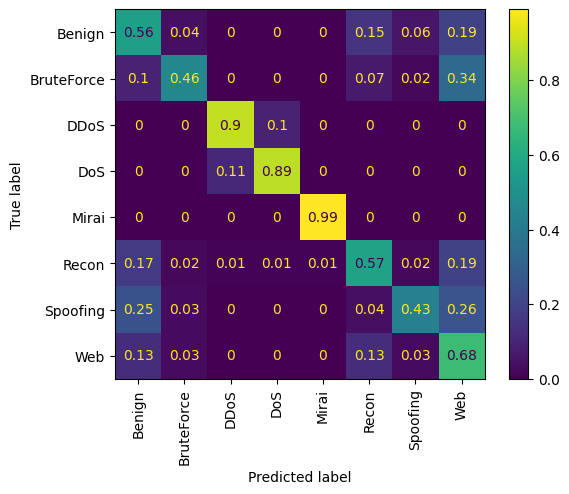

In [223]:
k_nearest_neighbors = KNeighborsClassifier()
k_nearest_neighbors.fit(data.x_train, data.y_train)
y_pred = k_nearest_neighbors.predict(data.x_test)

print(
    classification_report(data.y_test, y_pred, target_names=np.unique(y_pred))
)

accuracy = accuracy_score(data.y_test, y_pred)
precision = precision_score(data.y_test, y_pred, average="macro")
recall = recall_score(data.y_test, y_pred, average="macro")
f1 = f1_score(data.y_test, y_pred, average="macro")

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}"
)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

      Benign       0.74      0.66      0.70       195
  BruteForce       0.27      0.59      0.37        41
        DDoS       0.96      0.64      0.77      6726
         DoS       0.37      0.88      0.52      1580
       Mirai       0.99      0.98      0.99       457
       Recon       0.55      0.54      0.54       166
    Spoofing       0.62      0.49      0.55        77
         Web       0.63      0.73      0.68       194

    accuracy                           0.70      9436
   macro avg       0.64      0.69      0.64      9436
weighted avg       0.84      0.70      0.73      9436



<Figure size 2000x1000 with 0 Axes>

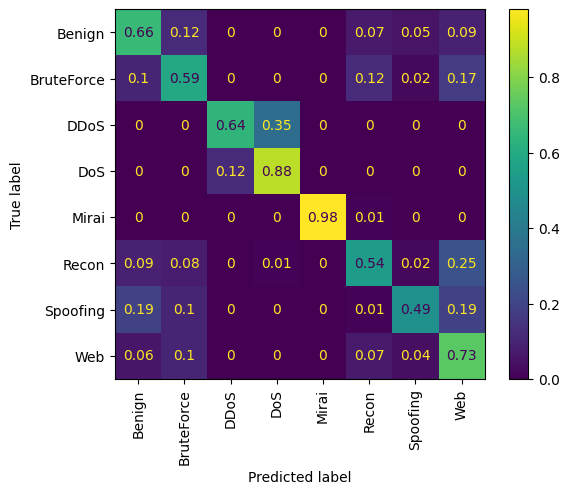

In [224]:
support_vector_classification = SVC()
support_vector_classification.fit(data.x_train, data.y_train)
y_pred = support_vector_classification.predict(data.x_test)

print(
    classification_report(data.y_test, y_pred, target_names=np.unique(y_pred))
)

accuracy = accuracy_score(data.y_test, y_pred)
precision = precision_score(data.y_test, y_pred, average="macro")
recall = recall_score(data.y_test, y_pred, average="macro")
f1 = f1_score(data.y_test, y_pred, average="macro")

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}"
)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

      Benign       0.70      0.72      0.71       195
  BruteForce       0.18      0.63      0.28        41
        DDoS       0.96      0.62      0.75      6726
         DoS       0.36      0.88      0.52      1580
       Mirai       1.00      0.98      0.99       457
       Recon       0.30      0.31      0.31       166
    Spoofing       0.49      0.52      0.51        77
         Web       0.46      0.59      0.52       194

    accuracy                           0.67      9436
   macro avg       0.56      0.66      0.57      9436
weighted avg       0.83      0.67      0.71      9436



<Figure size 2000x1000 with 0 Axes>

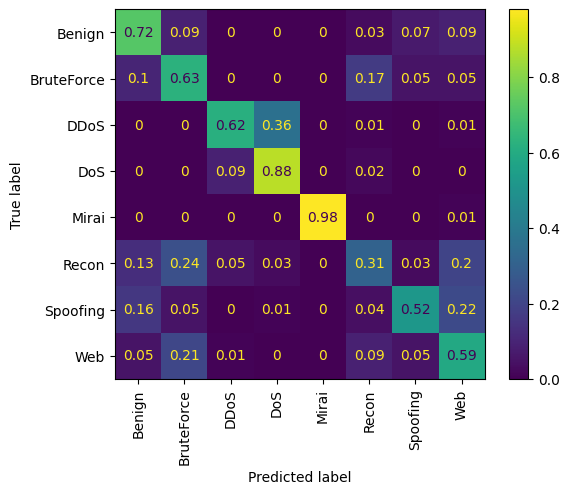

In [225]:
logistic_regression = LogisticRegression(n_jobs=-1, max_iter=10000)
logistic_regression.fit(data.x_train, data.y_train)
y_pred = logistic_regression.predict(data.x_test)

print(
    classification_report(data.y_test, y_pred, target_names=np.unique(y_pred))
)

accuracy = accuracy_score(data.y_test, y_pred)
precision = precision_score(data.y_test, y_pred, average="macro")
recall = recall_score(data.y_test, y_pred, average="macro")
f1 = f1_score(data.y_test, y_pred, average="macro")

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}"
)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

      Benign       0.64      0.23      0.33       195
  BruteForce       0.12      0.51      0.20        41
        DDoS       1.00      0.46      0.63      6726
         DoS       0.31      0.98      0.47      1580
       Mirai       1.00      0.98      0.99       457
       Recon       0.84      0.19      0.31       166
    Spoofing       0.14      0.21      0.17        77
         Web       0.26      0.70      0.38       194

    accuracy                           0.57      9436
   macro avg       0.54      0.53      0.43      9436
weighted avg       0.85      0.57      0.60      9436



<Figure size 2000x1000 with 0 Axes>

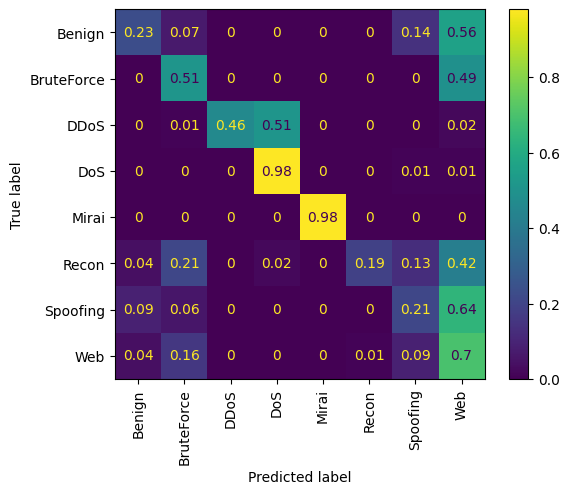

In [226]:
gaussian_naive_bayes = GaussianNB()
gaussian_naive_bayes.fit(data.x_train, data.y_train)
y_pred = gaussian_naive_bayes.predict(data.x_test)

print(
    classification_report(data.y_test, y_pred, target_names=np.unique(y_pred))
)

accuracy = accuracy_score(data.y_test, y_pred)
precision = precision_score(data.y_test, y_pred, average="macro")
recall = recall_score(data.y_test, y_pred, average="macro")
f1 = f1_score(data.y_test, y_pred, average="macro")

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}"
)

c:\Users\antonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

      Benign       0.82      0.86      0.84       195
  BruteForce       0.96      0.54      0.69        41
        DDoS       1.00      1.00      1.00      6726
         DoS       1.00      1.00      1.00      1580
       Mirai       1.00      0.99      0.99       457
       Recon       0.75      0.75      0.75       166
    Spoofing       0.88      0.66      0.76        77
         Web       0.75      0.91      0.82       194

    accuracy                           0.98      9436
   macro avg       0.89      0.84      0.86      9436
weighted avg       0.99      0.98      0.98      9436



<Figure size 2000x1000 with 0 Axes>

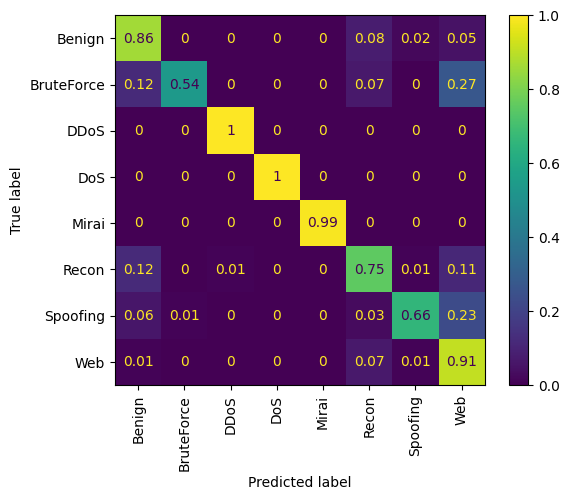

In [227]:
random_forest = RandomForestClassifier()
random_forest.fit(data.x_train, data.y_train)
y_pred = random_forest.predict(data.x_test)

print(
    classification_report(data.y_test, y_pred, target_names=np.unique(y_pred))
)

accuracy = accuracy_score(data.y_test, y_pred)
precision = precision_score(data.y_test, y_pred, average="macro")
recall = recall_score(data.y_test, y_pred, average="macro")
f1 = f1_score(data.y_test, y_pred, average="macro")

print(
    f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}"
)